In [319]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as rnd
import random
import math
import copy

## 0. Parameters settings

In [320]:
num_pop = 100
dimension = 2
size = 7 #(-100<= X <=100 by binary)

crossover_prob = 0.7 # 0.7, 0.8, 0.9
mutation_prob = 0.05 # 0.01, 0.03, 0.05

function_selected = "Rastrigin" #Sphere #Rastrigin 

## 1. Functions

### 1.1. About chromosomes

In [321]:
"""
Generate random solution
"""
def generate_random_solution(size):
    solution = []
    chromosome = []
    sign = []
    
    # Chromosome
    current_size = 0
    while current_size < size:
        chromosome.append(random.randint(0,1))
        current_size = current_size + 1
    
    # Sign + -
    sign_candidate = [-1, 1]
    sign.append(random.choice(sign_candidate))

    # Merge solution
    solution.append(chromosome)
    solution.append(sign)
    # print(solution)

    return solution

"""
Chromosome genotype solution value function
"""

def chromosome_bin_to_decimal(chromosome): 
    #
    power = len(chromosome[0])-1    
    sum = 0
    
    #
    for idx in range(0,len(chromosome[0])):
        sum = sum + (chromosome[0][idx]) * (2**power)
        power = power - 1
    
    return sum * chromosome[1][0]


### 1.2. Objective functions

In [322]:
"""
Sphere function(objective)
input: decimal
"""
def Sphere_function(x):
    return x**2

def Rastrigin_function(x):
    return (x**2 - 10 * math.cos(2*(math.pi)*x) + 10)


In [323]:
"""
Calculate objective function and judge the best solution
"""

def calculate_objective_function(solution_set):

    value_set = []
    for sol_idx in range(0, len(solution_set)):
        
        sum = 0
        if function_selected == 'Sphere':    
            for dim in range(0,dimension):
                sum = sum + Sphere_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
            
        elif function_selected == 'Rastrigin':    
            for dim in range(0,dimension):
                sum = sum + Rastrigin_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
        else:
            print("PLEASE SET YOUR FUNCTION")

    # print(value_set)
    
    return value_set

### 1.3. About selection

In [324]:
"""
Calculate objective function and compose selection probability (1st: 50%, 2nd: 25%, 3rd: 12.5% ...)
"""

def calculate_obj_and_compose_selection_probability(solution_set):

    value_set = calculate_objective_function(solution_set)
    
    # Ascending
    temp_df = pd.DataFrame({"index":(range(0,num_pop)), "obj.val": value_set})
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    increasing_index = temp_df['index'].values.tolist()
       
    #
    selection_prob = [-999 for i in range(0,num_pop)]
    sum1_idx = 0
    for count in range(0,(num_pop-1)):
        #
        # print(f'{count}: {increasing_index}')
        where_point = increasing_index.index(count)
        selection_prob[where_point] = 0.5*(0.5)**(count)
        sum1_idx = sum1_idx + 0.5*(0.5)**(count)
    
    where_point = increasing_index.index(num_pop-1)
    selection_prob[where_point] = 1 - sum1_idx
    
    # print(f'selection_prob: {selection_prob}')
            
    return selection_prob



In [325]:
"""
Calculate objective function and compose selection probability based on reciprocal of fitness values
"""
def calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set):
    
    value_set = calculate_objective_function(solution_set)
    # print(value_set)
    
    # Reciprocal
    value_recip_set = []
    for v in value_set:
        if v == 0:
            value_recip_set.append(0)
        else:
            value_recip_set.append(1/v)
    
    denom = np.sum(value_recip_set)
    selection_prob = []
    for i in value_recip_set:
        selection_prob.append(i/denom)
    
            
    return selection_prob

### 1.4. Crossver and Mutation

In [326]:
"""
One-point crossover
: between same dimension

"""
def execute_crossover_standard(solution_1, solution_2):
    
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)
    # print(f'solution tmp: {solution_1_tmp}, {solution_2_tmp}')
    # Crossover
    dim = 0
    while dim < dimension:
        
        # Save current solutions
        current_sol1 = solution_1_tmp[dim][0]
        current_sol2 = solution_2_tmp[dim][0]
        # print(f'{current_sol1}\n{current_sol2}')
        
        # Copy the new solution from the current solutions
        new_sol1 = copy.deepcopy(current_sol1)
        new_sol2 = copy.deepcopy(current_sol2)
        
        # Find location for one-point crossover
        point_loc = random.randint(1,(len(current_sol1)-2))
        
        # print(f'len: {(len(current_sol1)-1)}')
        
        # print(f'point_loc: {point_loc}')
        
        for loc_idx in range(0, point_loc):
            new_sol1[loc_idx] = current_sol2[loc_idx]
            new_sol2[loc_idx] = current_sol1[loc_idx]
        
        solution_1_tmp[dim][0] = new_sol1
        solution_2_tmp[dim][0] = new_sol2
        
        # Update
        dim = dim + 1

    # print(f'{solution_1_tmp}\n{solution_2_tmp}')
    return solution_1_tmp, solution_2_tmp

"""
Modified crossover: crop & merge
"""
def execute_crossover_modified(solution_1, solution_2):
        
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)
    print(f'solution tmp: {solution_1_tmp}, {solution_2_tmp}')
    # Crossover
    dim = 0
    while dim < dimension:
        
        # Save current solutions
        current_sol1 = solution_1_tmp[dim][0]
        current_sol2 = solution_2_tmp[dim][0]
        print(f'{current_sol1}\n{current_sol2}')
        
        # Copy the new solution from the current solutions
        new_sol1 = copy.deepcopy(current_sol1)
        new_sol2 = copy.deepcopy(current_sol2)
                
        # CROP: Find locations for crop in consecutive numbers (0~5) 
        crop_loc = random.randint(0,(len(current_sol1)-2))
        print(f'crop_loc: {crop_loc}')
        
        # MERGE: Find two locations for merge (7C2)
        merge_loc = list(range(len(current_sol1)))
        merge_list = random.sample(merge_loc, 2)
        print(f'merge_list: {merge_list}')
        
        #
        new_sol1[crop_loc] = current_sol2[merge_list[0]]
        new_sol1[crop_loc+1] = current_sol2[merge_list[1]]
        
        new_sol2[merge_list[0]] = current_sol1[crop_loc]
        new_sol2[merge_list[1]] = current_sol1[crop_loc+1]   
                
        solution_1_tmp[dim][0] = new_sol1
        solution_2_tmp[dim][0] = new_sol2
                
        # Update
        dim = dim + 1

    # print(f'{solution_1_tmp}\n{solution_2_tmp}')
    return solution_1_tmp, solution_2_tmp


In [327]:
"""
Standard mutation
: select only one
"""
def execute_mutation_standard(new_solution_1, new_solution_2):

    remember_signal = -99
    # Select
    if random.random() <= 0.5:
        mutation_target_chromosome = copy.deepcopy(new_solution_1)
        remember_signal = 1
    else:
        mutation_target_chromosome = copy.deepcopy(new_solution_2)
        remember_signal = 2
        
    # print("!: ",remember_signal)

    # Choose the location randomly along all dimension 
    dim = 0
    while dim < dimension:
        temp_chromosome = mutation_target_chromosome[dim][0]
        # print(temp_chromosome)
        
        point_loc = random.randint(0,(len(temp_chromosome)-1))
        
        # print(f'{point_loc}: {temp_chromosome[point_loc]}')
        
        if temp_chromosome[point_loc] == 0:
            temp_chromosome[point_loc] = 1
        else:
            temp_chromosome[point_loc] = 0
            
        # print(temp_chromosome)
        # print("\n")
        dim = dim + 1

    if remember_signal == 1:
        new_solution_1 = copy.deepcopy(mutation_target_chromosome)
    elif remember_signal == 2:
        new_solution_2 = copy.deepcopy(mutation_target_chromosome)
    else:
        print("error")
        
    return new_solution_1, new_solution_2

"""
Modified mutation
: select 1~3
"""
def execute_mutation_modified(new_solution_1, new_solution_2):
    pass

## 2. Generate initial population
[[0, 0, 1, 0, 0, 0, 0], [sign]]

In [328]:
"""
Example of chromosome
"""
chromosome = generate_random_solution(size)
val = chromosome_bin_to_decimal(chromosome)

print(chromosome)
print(val)

[[0, 0, 0, 0, 0, 1, 1], [1]]
3


In [329]:
"""
Generate intial population
"""
solution_set = []

successful_pop = 1
while successful_pop <= num_pop:
    
    # Generate    
    temp_solution_set = []
    success_dim = 0
    while success_dim < dimension:
        temp_chromosome = generate_random_solution(size)
        val = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution: -100 ~ +100
        if (val >= -100) &  (val <= 100):
            temp_solution_set.append(temp_chromosome)
            success_dim = success_dim + 1
        else:
            pass
            # print(f'Infeasible!...')
    # Append
    solution_set.append(temp_solution_set)
    # print(f'Generated num of population: {successful_pop}')
    
    # Update
    successful_pop = successful_pop + 1
    
# OUTPUT: solution_set

In [330]:
for i in range(0, len(solution_set)):
    
    print(solution_set[i])

[[[1, 0, 1, 0, 1, 0, 0], [1]], [[1, 0, 0, 0, 0, 0, 0], [1]]]
[[[0, 0, 1, 0, 1, 1, 0], [-1]], [[0, 1, 0, 1, 0, 1, 0], [-1]]]
[[[1, 0, 1, 1, 1, 0, 0], [1]], [[0, 1, 1, 1, 0, 1, 1], [1]]]
[[[1, 0, 0, 0, 1, 0, 1], [-1]], [[0, 1, 0, 0, 1, 1, 1], [1]]]
[[[0, 0, 0, 1, 0, 0, 1], [1]], [[0, 1, 0, 1, 0, 1, 0], [-1]]]
[[[0, 1, 1, 1, 0, 1, 1], [1]], [[0, 0, 1, 0, 0, 0, 1], [1]]]
[[[0, 0, 0, 1, 0, 0, 0], [1]], [[1, 0, 0, 1, 1, 1, 0], [-1]]]
[[[0, 1, 0, 0, 0, 1, 1], [1]], [[1, 0, 1, 0, 1, 0, 0], [1]]]
[[[0, 1, 1, 1, 0, 1, 0], [1]], [[1, 1, 0, 0, 1, 0, 0], [1]]]
[[[1, 0, 0, 1, 0, 1, 1], [1]], [[1, 0, 0, 0, 0, 0, 1], [-1]]]
[[[0, 0, 0, 0, 1, 0, 0], [-1]], [[0, 1, 1, 0, 1, 0, 1], [-1]]]
[[[1, 0, 1, 1, 1, 0, 1], [-1]], [[0, 1, 1, 1, 1, 1, 1], [1]]]
[[[0, 1, 1, 1, 1, 0, 1], [1]], [[1, 0, 0, 0, 1, 0, 0], [-1]]]
[[[0, 1, 0, 1, 1, 0, 0], [-1]], [[1, 0, 1, 1, 0, 0, 1], [1]]]
[[[0, 0, 0, 0, 0, 0, 0], [1]], [[0, 0, 1, 0, 0, 1, 1], [1]]]
[[[0, 1, 1, 0, 0, 1, 0], [1]], [[1, 1, 0, 0, 1, 0, 0], [1]]]
[[[0, 0, 1, 0

## 3. Roulette-wheel selection

In [331]:
"""
Set the roulette-wheel and select two individual solutions
"""
obj_list = calculate_objective_function(solution_set)
print(obj_list)

# selection probability based on fitness values
selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
print(selection_prob)


# select only two chromosomes within 1~Npop
num_list = list(range(0,(num_pop)))
print(num_list)


selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
print(selected_pop)


[11152.0, 2248.0, 11945.0, 6282.0, 1845.0, 3770.0, 6148.0, 8281.0, 13364.0, 9850.0, 2825.0, 12618.0, 8345.0, 9857.0, 361.0, 12500.0, 5384.0, 3218.0, 4330.0, 4033.0, 13757.0, 6757.0, 36.0, 3665.0, 13480.0, 5525.0, 3701.0, 11417.0, 4420.0, 4168.0, 4545.0, 14645.0, 3125.0, 11540.0, 3530.0, 16362.0, 5737.0, 8036.0, 1684.0, 11252.0, 3536.0, 11909.0, 9677.0, 5194.0, 17861.0, 10090.0, 8101.0, 7780.0, 1972.0, 1568.0, 16250.0, 7696.0, 9594.0, 6305.0, 15426.0, 1285.0, 5465.0, 1445.0, 4405.0, 12389.0, 9005.0, 5309.0, 9922.0, 11321.0, 2165.0, 11713.0, 8164.0, 6565.0, 2725.0, 6938.0, 8861.0, 3293.0, 4210.0, 1021.0, 10737.0, 8282.0, 8450.0, 7272.0, 674.0, 2900.0, 15380.0, 14545.0, 2729.0, 4338.0, 5569.0, 2169.0, 7045.0, 6976.0, 1513.0, 10273.0, 4069.0, 1620.0, 2273.0, 149.0, 1681.0, 1250.0, 3492.0, 8833.0, 4409.0, 12200.0]
[1.1920928955078125e-07, 5.048709793414476e-29, 3.0517578125e-05, 1.6543612251060553e-24, 5.293955920339377e-23, 1.262177448353619e-29, 1.3877787807814457e-17, 3.469446951953614e-

## 4. Crossover

In [332]:
"""
Execute crossover with crossover probability: select only two
"""
# Selected two solutions
solution_1 = solution_set[selected_pop[0]]
solution_2 = solution_set[selected_pop[1]]
print(f'current\n{solution_1}\n{solution_2}')

if random.random() <= crossover_prob:
    new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
    print(f'new\n{new_solution_1}\n{new_solution_2}')


current
[[[0, 0, 0, 0, 1, 1, 1], [-1]], [[0, 0, 1, 1, 0, 0, 1], [1]]]
[[[0, 1, 0, 1, 1, 0, 0], [-1]], [[1, 0, 1, 1, 0, 0, 1], [1]]]
new
[[[0, 1, 0, 1, 1, 1, 1], [-1]], [[1, 0, 1, 1, 0, 0, 1], [1]]]
[[[0, 0, 0, 0, 1, 0, 0], [-1]], [[0, 0, 1, 1, 0, 0, 1], [1]]]


## 5. Mutation

In [333]:
"""
Execute muatation with crossover probability: select only one solution between two solutions
"""

print(f'current\n{new_solution_1}\n{new_solution_2}')
if random.random() <= mutation_prob: # mutation_prob
    new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
    print(f'new\n{new_solution_1}\n{new_solution_2}')

current
[[[0, 1, 0, 1, 1, 1, 1], [-1]], [[1, 0, 1, 1, 0, 0, 1], [1]]]
[[[0, 0, 0, 0, 1, 0, 0], [-1]], [[0, 0, 1, 1, 0, 0, 1], [1]]]


## 6. Alternate

In [334]:
"""
Alternative I
"""
def alternative_1(solution_set, new_solution_1, new_solution_2):
   
    solution_set[selected_pop[0]] = new_solution_1
    solution_set[selected_pop[1]] = new_solution_2
    
    return solution_set

In [335]:
"""
Alternative II
"""
def alternative_2(solution_set, new_solution_1, new_solution_2):
    alt2_solution_set = copy.deepcopy(solution_set)
    alt2_obj_set = copy.deepcopy(calculate_objective_function(solution_set))

    
    if function_selected == 'Sphere':
        # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Sphere_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Sphere_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    elif function_selected == 'Rastrigin':
            # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    else:
        print("PLEASE SET YOUR FUNCTION!")

    # Remove twice
    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+2)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+1)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    # print(alt2_obj_set)
    

    # Replace solution_set with alt2_solution_set
    return alt2_solution_set

## 7. Indicator plot(operators analysis)

In [336]:
"""
Take coordinates under dimension
"""
def take_coordinates(solution_set):
    
    x_set = []
    for sol_idx in range(0, len(solution_set)):
        
        x_tmp = []
        for dim in range(0,dimension):
            x_tmp.append(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
        x_set.append(x_tmp)

    return x_set
        
    # return value_set

In [337]:
"""
Calculate distances between D points(dimensions), Euclidean
"""
# def euclidean_distance(solution_set, iteration):
plot_for_indicators = take_coordinates(solution_set) 

print(plot_for_indicators)

max_dist = -999

# p ~ q
for i in range(0,num_pop):
    
    p_set = plot_for_indicators[i]
    for j in range(0, num_pop):
        q_set = plot_for_indicators[j]
        
        sum = 0
        for dim in range(0,dimension):
            sum = (p_set[dim]-q_set[dim])**2
        
        distance = math.sqrt(sum)
        if max_dist <= distance:
            max_dist = distance

print(max_dist)
# return max_dist


[[84, 64], [-22, -42], [92, 59], [-69, 39], [9, -42], [59, 17], [8, -78], [35, 84], [58, 100], [75, -65], [-4, -53], [-93, 63], [61, -68], [-44, 89], [0, 19], [50, 100], [22, -70], [-43, 37], [63, -19], [-28, -57], [-91, -74], [81, 14], [0, 6], [-56, -23], [-78, 86], [70, -25], [55, -26], [-91, -56], [64, -18], [62, 18], [36, -57], [82, -89], [-41, 38], [44, -98], [-7, -59], [-99, -81], [51, -56], [70, -56], [30, 28], [-74, 76], [20, 56], [-97, 50], [-29, -94], [-63, 35], [-94, -95], [99, 17], [-1, 90], [-74, 48], [-36, 26], [-28, -28], [-95, 85], [60, 64], [-63, 75], [47, 64], [-99, -75], [-33, -14], [64, 37], [-34, -17], [-7, -66], [-95, -58], [-13, 94], [-53, 50], [-99, 11], [64, 85], [41, 22], [-48, 97], [-42, 80], [-74, -33], [-18, 49], [-83, 7], [-5, -94], [38, -43], [-31, -57], [-30, -11], [39, -96], [89, -19], [-65, -65], [54, 66], [-7, 25], [52, 14], [-76, -98], [-96, -73], [5, 52], [57, 33], [63, 40], [-12, 45], [31, 78], [80, 24], [-37, -12], [-87, 52], [-63, 10], [-36, 18],

In [338]:
ppp = plot_for_indicators[0]
qqq = plot_for_indicators[1]

print(ppp, qqq)

print(ppp[1] - qqq[1])
print(dimension)

[84, 64] [-22, -42]
106
2


In [339]:
"""
Basis plot
"""
def basis_plot(solution_set, iteration):
    plot_for_indicators = take_coordinates(solution_set)    
    x, y = zip(*plot_for_indicators)
    
    plt.scatter(x,y, s=12, color='black')
    plt.scatter(0,0, s=12, color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([-120, 120])      # X축의 범위: [xmin, xmax]
    plt.ylim([-120, 120]) 
    plt.title(f'Iteration: {iteration}, Crossover_prob: {crossover_prob}, Mutation_prob: {mutation_prob}')
    plt.show()

    print(f'plot_for_indicators: {plot_for_indicators}')
    print(f'minimum value: {min(calculate_objective_function(solution_set))}')
    
"""
Exploration
: Area of maximal radius circle
"""







"""
Exploitation
: (current area) / (initial area)
"""


print("!")


!


In [340]:
plot_for_indicators = take_coordinates(solution_set)
print(plot_for_indicators)

[[84, 64], [-22, -42], [92, 59], [-69, 39], [9, -42], [59, 17], [8, -78], [35, 84], [58, 100], [75, -65], [-4, -53], [-93, 63], [61, -68], [-44, 89], [0, 19], [50, 100], [22, -70], [-43, 37], [63, -19], [-28, -57], [-91, -74], [81, 14], [0, 6], [-56, -23], [-78, 86], [70, -25], [55, -26], [-91, -56], [64, -18], [62, 18], [36, -57], [82, -89], [-41, 38], [44, -98], [-7, -59], [-99, -81], [51, -56], [70, -56], [30, 28], [-74, 76], [20, 56], [-97, 50], [-29, -94], [-63, 35], [-94, -95], [99, 17], [-1, 90], [-74, 48], [-36, 26], [-28, -28], [-95, 85], [60, 64], [-63, 75], [47, 64], [-99, -75], [-33, -14], [64, 37], [-34, -17], [-7, -66], [-95, -58], [-13, 94], [-53, 50], [-99, 11], [64, 85], [41, 22], [-48, 97], [-42, 80], [-74, -33], [-18, 49], [-83, 7], [-5, -94], [38, -43], [-31, -57], [-30, -11], [39, -96], [89, -19], [-65, -65], [54, 66], [-7, 25], [52, 14], [-76, -98], [-96, -73], [5, 52], [57, 33], [63, 40], [-12, 45], [31, 78], [80, 24], [-37, -12], [-87, 52], [-63, 10], [-36, 18],

## @@ Iteration test @@

In [341]:
MAX_ITR = 1000

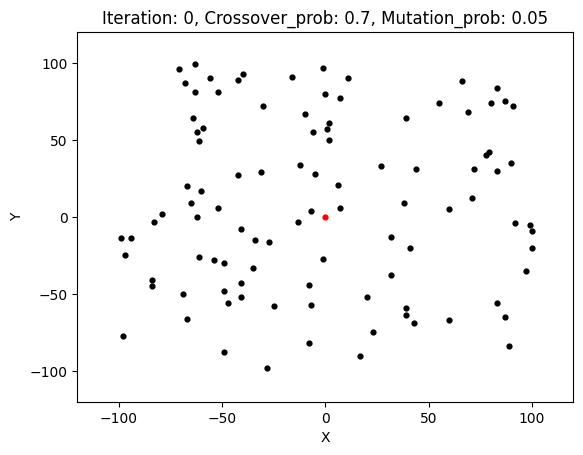

plot_for_indicators: [[-97, -25], [32, -13], [-42, 27], [71, 12], [20, -52], [-68, 87], [69, 68], [80, 74], [-13, -3], [7, 6], [39, 64], [-52, 81], [-49, -30], [32, -38], [2, 50], [23, -75], [99, -5], [7, 77], [43, -69], [-41, -52], [-84, -41], [100, -20], [-67, -66], [-8, -82], [89, -84], [-40, 93], [2, 61], [-6, 55], [-7, 4], [-61, 49], [66, 88], [-63, 99], [-62, 0], [-64, 64], [39, -64], [-8, -44], [-41, -8], [79, 42], [-83, -3], [-10, 67], [-99, -14], [39, -59], [60, -67], [-84, -45], [-7, -57], [-62, 55], [-69, -50], [-49, -88], [-54, -28], [-28, -98], [-63, 81], [27, 33], [-49, -48], [-1, -27], [83, 84], [-27, -16], [-71, 96], [-52, 6], [83, -56], [17, -90], [-65, 9], [-61, -26], [-31, 29], [-16, 91], [87, 75], [92, -4], [-94, -14], [-59, 58], [100, -9], [-1, 97], [1, 57], [-67, 20], [-98, -77], [-35, -33], [-79, 2], [-30, 72], [72, 31], [-47, -56], [91, 72], [97, -35], [41, -20], [-56, 90], [87, -65], [-34, -15], [-42, 89], [83, 30], [-12, 34], [-5, 28], [-41, -43], [6, 21], [78

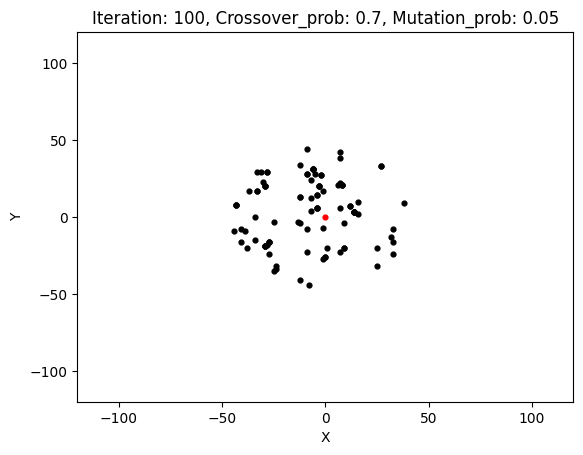

plot_for_indicators: [[32, -13], [-13, -3], [7, 6], [-7, 4], [-8, -44], [-41, -8], [27, 33], [-1, -27], [-27, -16], [-31, 29], [-34, -15], [-12, 34], [-5, 28], [6, 21], [38, 9], [16, 10], [14, 3], [14, 3], [14, 3], [14, 3], [-2, 27], [-2, 27], [-30, 23], [-24, -34], [0, -26], [0, -26], [-3, 20], [-3, 20], [-34, 0], [-9, 44], [9, -20], [9, -20], [25, -20], [-4, 6], [-4, 6], [7, 38], [-1, 17], [1, -20], [-29, 20], [-6, 31], [-29, 20], [-6, 31], [-29, 20], [-6, 31], [12, 7], [12, 7], [8, 21], [-28, 29], [-28, 29], [-38, -20], [-39, -9], [33, -24], [7, -23], [-44, -9], [-12, -41], [-4, 14], [16, 2], [8, 21], [14, 3], [-33, 17], [-33, 17], [-37, 17], [-33, 29], [-29, -19], [-12, 13], [-29, -19], [-12, 13], [-25, -35], [-28, -18], [-3, 20], [8, 21], [-9, 28], [7, 42], [-9, -23], [25, -32], [9, -4], [7, 22], [-9, 28], [-4, 14], [-4, 6], [-7, 12], [-43, 8], [-43, 8], [-43, 8], [-6, 31], [27, 33], [-24, -32], [-12, -4], [-25, -3], [-1, -7], [-7, 24], [33, -16], [-27, -24], [-27, -16], [-29, -19

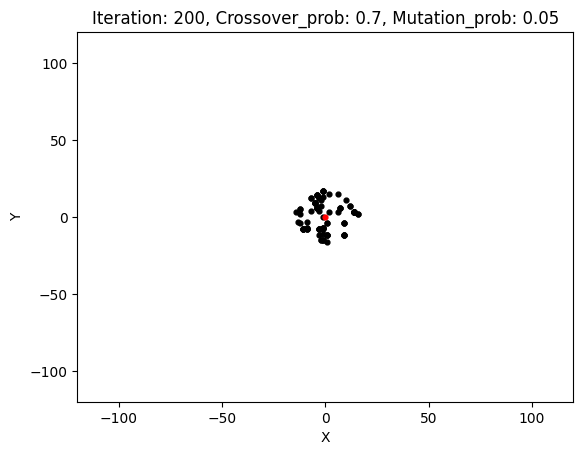

plot_for_indicators: [[-13, -3], [7, 6], [-7, 4], [14, 3], [14, 3], [14, 3], [14, 3], [-4, 6], [-4, 6], [-1, 17], [12, 7], [12, 7], [-4, 14], [16, 2], [14, 3], [9, -4], [-4, 14], [-4, 6], [-7, 12], [-12, -4], [-1, -7], [-9, -8], [-1, -11], [-5, 9], [2, 3], [6, 15], [-12, 2], [-3, -8], [-1, -7], [-1, -7], [-1, -7], [-3, 4], [14, 3], [14, 3], [9, -4], [9, -4], [7, 6], [-2, 7], [14, 3], [2, 15], [-2, 11], [-11, -8], [-11, -8], [-9, -8], [14, 3], [14, 3], [14, 3], [14, 3], [-14, 3], [-11, -8], [-11, -8], [-3, 12], [16, 2], [-1, 0], [-3, -8], [-3, -8], [-3, -8], [-1, 17], [-1, 17], [-1, 17], [1, -12], [1, -12], [1, -12], [1, -12], [-9, -7], [1, -16], [-2, -15], [-2, -15], [9, -12], [9, -12], [-1, 13], [-5, 9], [-5, 9], [-5, 9], [-5, 9], [-1, -15], [1, -4], [-1, -15], [1, -4], [-12, 5], [-3, 12], [-12, 5], [9, -12], [7, 6], [10, 11], [-3, -12], [-4, 14], [-4, 6], [-11, -8], [-4, 14], [-9, -8], [-7, 12], [-4, 6], [14, 3], [6, 3], [-9, -7], [9, -12], [-1, -8], [-9, -3], [-1, -15]]
minimum valu

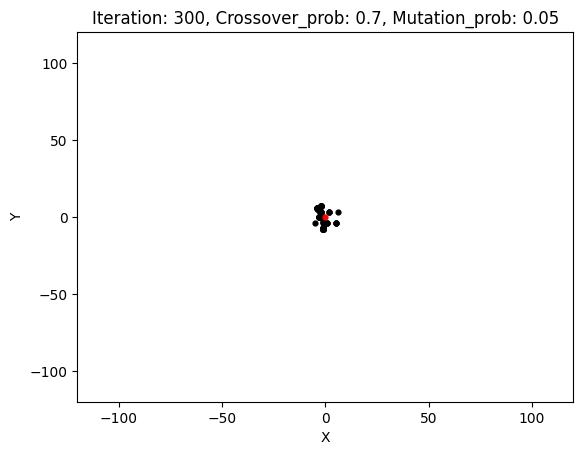

plot_for_indicators: [[-4, 6], [-4, 6], [-4, 6], [-1, -7], [2, 3], [-1, -7], [-1, -7], [-1, -7], [-3, 4], [-2, 7], [-1, 0], [1, -4], [1, -4], [-4, 6], [-4, 6], [6, 3], [-1, -8], [2, 3], [-1, -7], [-1, -8], [-1, -8], [-1, -8], [-1, -8], [-1, -8], [-4, 6], [-2, 3], [-2, 7], [-4, 5], [-3, 0], [-3, 0], [-2, 7], [-2, 7], [-2, 7], [-1, -8], [-2, 7], [-1, -7], [-1, -7], [-1, -8], [-1, -8], [-1, -8], [-1, -8], [-1, -3], [-1, -8], [-1, -8], [-1, -8], [-2, 3], [-3, 0], [-1, -8], [-1, -8], [-1, -3], [5, -4], [5, -4], [1, -4], [-1, -7], [-5, -4], [-1, 0], [-1, 0], [-3, 0], [-3, 0], [-3, 0], [-1, -8], [-1, -8], [-2, 7], [-1, -8], [-1, -8], [-1, -8], [-1, -8], [-3, 0], [-3, 0], [-1, -4], [-1, -8], [-1, -8], [-1, -8], [-3, 0], [-3, 0], [-1, -8], [-2, 7], [-1, -8], [5, -4], [-2, 7], [-2, 7], [-1, -7], [-2, 7], [-1, -8], [-1, -7], [-3, 0], [-1, -8], [-1, -8], [-1, -7], [-2, 7], [-1, -7], [-2, 7], [-1, -7], [-2, 7], [-2, 3], [-2, 7], [-2, 3], [-2, 7], [2, 3], [-3, 0]]
minimum value: 1.0


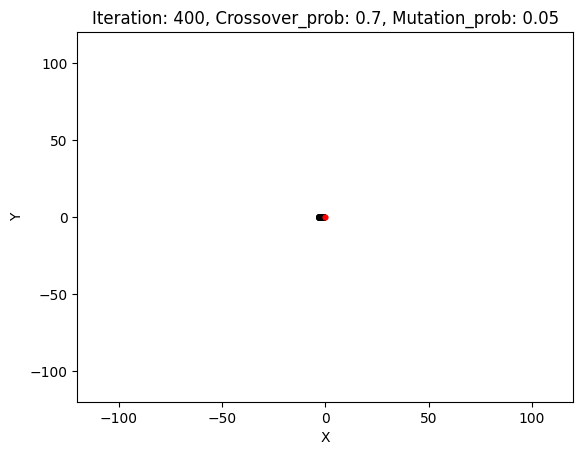

plot_for_indicators: [[-1, 0], [-3, 0], [-3, 0], [-3, 0], [-1, 0], [-1, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-1, 0], [-1, 0], [-1, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-1, 0], [-1, 0], [-3, 0], [-1, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-3, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-3, 0], [-1, 0], [-3, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-3, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-3, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-3, 0], [-1, 0], [-3, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0]]
minimum value: 1.0


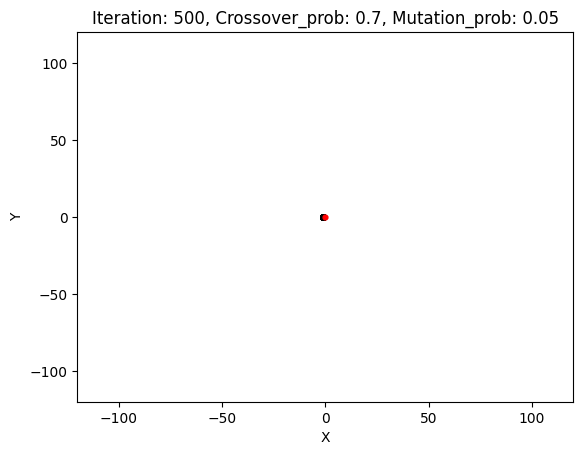

plot_for_indicators: [[-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0]]
minimum value: 1.0


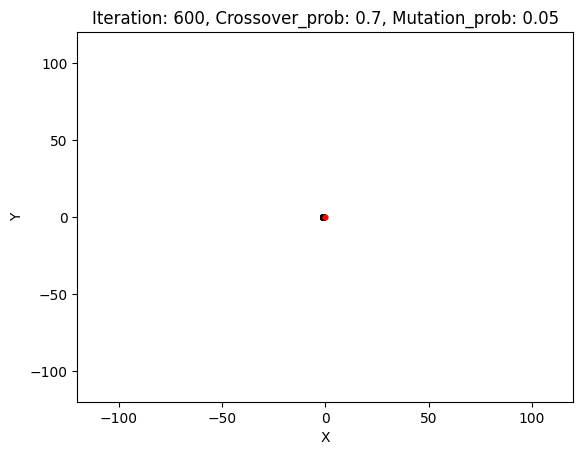

plot_for_indicators: [[-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0]]
minimum value: 1.0


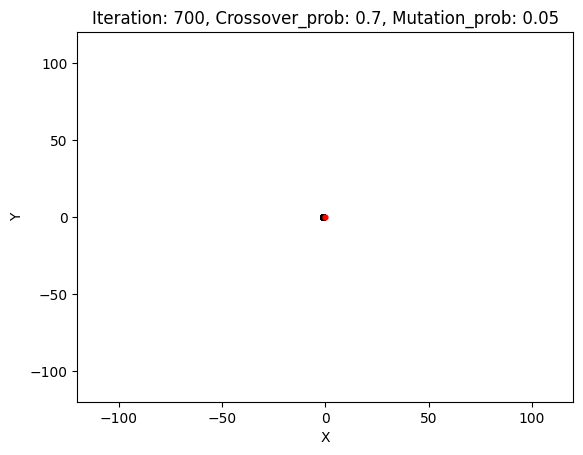

plot_for_indicators: [[-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0]]
minimum value: 1.0


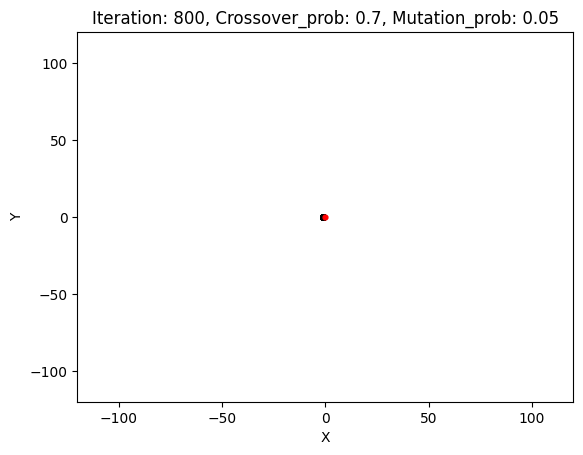

plot_for_indicators: [[-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0]]
minimum value: 1.0


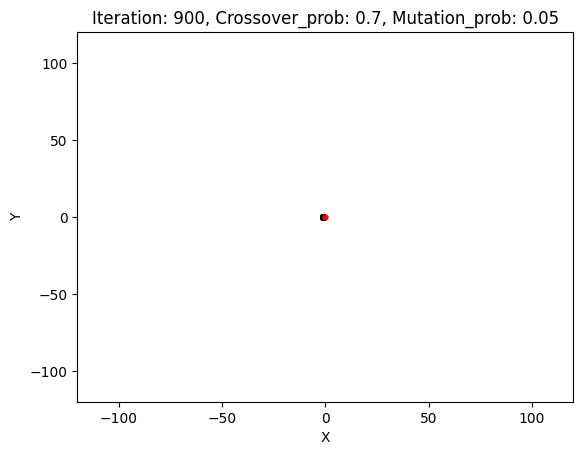

plot_for_indicators: [[-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0]]
minimum value: 1.0


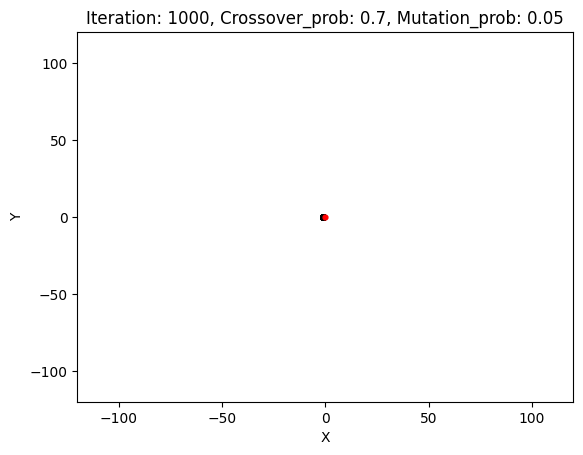

plot_for_indicators: [[-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0], [-1, 0]]
minimum value: 1.0


In [342]:
"""
Generate intial population
"""

list_for_plot = []

#
solution_set = []
successful_pop = 1
while successful_pop <= num_pop:
    
    # Generate    
    temp_solution_set = []
    success_dim = 0
    while success_dim < dimension:
        temp_chromosome = generate_random_solution(size)
        val = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution: -100 ~ +100
        if (val >= -100) &  (val <= 100):
            temp_solution_set.append(temp_chromosome)
            success_dim = success_dim + 1
        else:
            pass
            # print(f'Infeasible!...')
    # Append
    solution_set.append(temp_solution_set)
    # print(f'Generated num of population: {successful_pop}')
    
    # Update
    successful_pop = successful_pop + 1

iteration = 0
basis_plot(solution_set, iteration)



iteration = 1
while iteration <= MAX_ITR:

    """
    Set the roulette-wheel and select two individual solutions
    """

    # selection probability based on fitness values
    
    selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
    # selection_prob = calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set)

    # 1~Npop
    num_list = list(range(0,num_pop))
    selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
    # print(selected_pop)

    """
    Execute crossover with crossover probability: select only two
    """
    # Selected two solutions
    solution_1 = solution_set[selected_pop[0]]
    solution_2 = solution_set[selected_pop[1]]
    # print(f'current\n{solution_1}\n{solution_2}')

    if random.random() <= crossover_prob:
        new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
        # print(f'new\n{new_solution_1}\n{new_solution_2}')

    """
    Execute muatation with crossover probability: select only one solution between two solutions
    """

    # print(f'current\n{new_solution_1}\n{new_solution_2}')
    if random.random() <= mutation_prob: # mutation_prob
        new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
    # print(f'current\n{new_solution_1}\n{new_solution_2}')


    """
    Alternative I or II
    """
    solution_set = alternative_2(solution_set, new_solution_1, new_solution_2)    
    
    
    """
    Evaluation
    """
    iterative_solution_set = calculate_objective_function(solution_set)
    
    # print(f'{iteration} | Best solution {solution_set[iterative_solution_set.index(min(iterative_solution_set))]}, value: {min(iterative_solution_set)}, index: {iterative_solution_set.index(min(iterative_solution_set))}')
    list_for_plot.append(min(iterative_solution_set))
    
    """
    Basis plot
    """
    if iteration%100 == 0:
        basis_plot(solution_set, iteration)
        
        
    
    # Update
    iteration = iteration + 1



In [318]:
plt.figure(figsize=(20,6))
plt.plot(list_for_plot)
plt.show()

NameError: name 'list_for_plot' is not defined

<Figure size 2000x600 with 0 Axes>

In [552]:
"""
Develop indicators(Exploration/Exploitation)
"""

'\nDevelop indicators(Exploration/Exploitation)\n'

## Dev note
- 전반적으로 오류나는거 체크(len 범위 착각)
- selection 할때 1, 2등에 거의 몰빵해야 함 예) 50*(1/2)**(r-100)
- Update하고 나서 feasibility 체크 따로 안 해도 될까?

In [722]:
for r in range(0, 100):
    print(50*(0.5)**(r))

50.0
25.0
12.5
6.25
3.125
1.5625
0.78125
0.390625
0.1953125
0.09765625
0.048828125
0.0244140625
0.01220703125
0.006103515625
0.0030517578125
0.00152587890625
0.000762939453125
0.0003814697265625
0.00019073486328125
9.5367431640625e-05
4.76837158203125e-05
2.384185791015625e-05
1.1920928955078125e-05
5.9604644775390625e-06
2.9802322387695312e-06
1.4901161193847656e-06
7.450580596923828e-07
3.725290298461914e-07
1.862645149230957e-07
9.313225746154785e-08
4.6566128730773926e-08
2.3283064365386963e-08
1.1641532182693481e-08
5.820766091346741e-09
2.9103830456733704e-09
1.4551915228366852e-09
7.275957614183426e-10
3.637978807091713e-10
1.8189894035458565e-10
9.094947017729282e-11
4.547473508864641e-11
2.2737367544323206e-11
1.1368683772161603e-11
5.6843418860808015e-12
2.8421709430404007e-12
1.4210854715202004e-12
7.105427357601002e-13
3.552713678800501e-13
1.7763568394002505e-13
8.881784197001252e-14
4.440892098500626e-14
2.220446049250313e-14
1.1102230246251565e-14
5.551115123125783e-15
2

In [673]:
print(len(selection_prob))

num_list = list(range(1,(num_pop+1)))
selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)



100


ValueError: probabilities contain NaN